# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [2]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

Summary (Very Simply)
Part	What it does
__init__	Sets up the grid, the agent, bomb, and gold
get_available_actions()	Tells what moves are possible
agent_on_map()	Shows where the agent is (for debugging/visuals)
get_reward()	Tells the reward of any grid cell
make_step()	Moves the agent and gives reward for that move
check_state()	Checks if the agent reached gold or bomb (i.e., the game is over)

In [3]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [16]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""

        # Get current position
        current_position = self.environment.current_location

        # Sometimes explore randomly (epsilon percent of the time)
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)

        # Most of the time, choose the best action
        # Look at Q-values for all available actions
        q_values = []
        for action in available_actions:
            q_value = self.q_table[current_position][action]
            q_values.append(q_value)

        # Find the action with highest Q-value
        max_q_value = max(q_values)

        # If multiple actions have the same max value, choose randomly among them
        best_actions = []
        for i, action in enumerate(available_actions):
            if q_values[i] == max_q_value:
                best_actions.append(action)

        action = np.random.choice(best_actions)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""

        # Q-learning formula: Q(s,a) = Q(s,a) + α[r + γ·max(Q(s',a')) - Q(s,a)]

        # Get the old Q-value for this state and action
        old_q_value = self.q_table[old_state][action]

        # Find the maximum Q-value for the new state (best future action)
        future_q_values = list(self.q_table[new_state].values())
        max_future_q = max(future_q_values)

        # Calculate the new Q-value using the Q-learning formula
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_q - old_q_value)

        # Update the Q-table
        self.q_table[old_state][action] = new_q_value


In [17]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [18]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

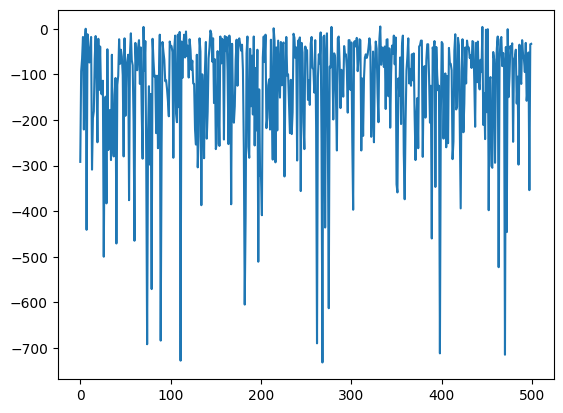

In [19]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

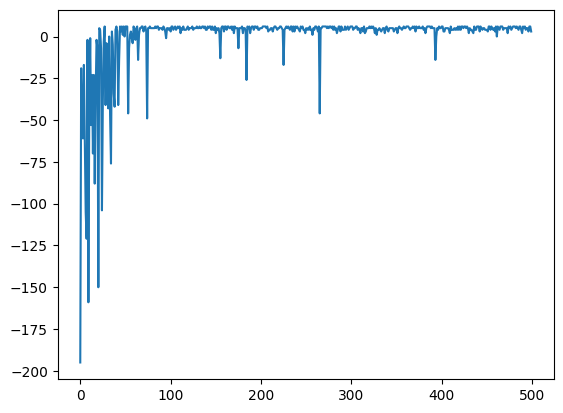

In [20]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [21]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		-0.31514410000000004
(0, 1)
	UP
		-0.2
	DOWN
		-0.11000000000000001
	LEFT
		-0.19
	RIGHT
		2.5879841788139304
(0, 2)
	UP
		4.646675159878363
	DOWN
		3.548428367917011
	LEFT
		0.015437874758234077
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		1.5195254775817624
	DOWN
		0
	LEFT
		9.99984315759571
	RIGHT
		0
(0, 5)
	UP
		-0.1
	DOWN
		-0.19298877963023003
	LEFT
		0.771382611
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.30000000000000004
	LEFT
		-0.24898142890000002
	RIGHT
		-0.319
(0, 7)
	UP
		-0.4
	DOWN
		-0.41080000000000005
	LEFT
		-0.391
	RIGHT
		-0.4
(1, 0)
	UP
		-0.47990000000000005
	DOWN
		-0.578843938993
	LEFT
		-0.49900000000000005
	RIGHT
		-0.49886176028981
(1, 1)
	UP
		-0.271
	DOWN
		-0.323357
	LEFT
		-0.319
	RIGHT
		3.2175495660182247
(1, 2)
	UP
		8.999999999999986
	DOWN
		2.8072060081244707
	LEFT
		0.17088989904287963
	RIGHT

1. Q-learning = learning by trial and error
Q just stands for "quality"

Initial Q-values = 0

At the start, the agent gives 0 points to all actions.

That means it has no idea what works — it’s starting from scratch.

As it plays and gets rewards, it updates those values.

ε-greedy policy
Balances exploring vs. using what it knows

ε value	What it means
1.0	Always random (fully exploring)
0.0	Never random (only uses what it knows)
0.1	10% random, 90% smart

🟨 Example:
If ε = 0.2, the agent will:

20% of the time → try a random move (exploring)

80% of the time → do what it thinks is best (exploiting)

This makes learning a bit stochastic — not totally predictable — so it can discover better strategies.

Task 5

--- Running Q-Learning on a 20x20 grid ---
This may take a minute or two...

--- Finished in 4.17 seconds ---
Plotting the learning curve...


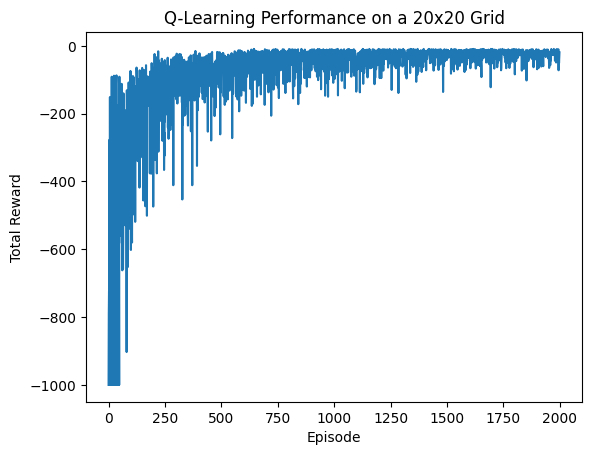

In [36]:
## === Task 5: Complete Code for a Larger Grid === ##

import timeit
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the new Class for the large grid ---
# We create a new GridWorld class that can be initialized with a custom size.
class GridWorld_Large:
    def __init__(self, size=20):
        # Set information about the gridworld based on the given size
        self.height = size
        self.width = size
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent at the bottom row
        self.current_location = (size - 1, np.random.randint(0, size))

        # Set locations for the bomb and the gold relative to the size
        self.bomb_location = (1, size - 2)
        self.gold_location = (0, size - 2)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# --- 2. Define the new play function for the large grid ---
def play_large_grid(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    reward_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True:
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True:
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL':
                environment.__init__(size=environment.height)
                game_over = True

        reward_per_episode.append(cumulative_reward)

    return reward_per_episode


# --- 3. Run the experiment ---
LARGE_GRID_SIZE = 20

print(f"--- Running Q-Learning on a {LARGE_GRID_SIZE}x{LARGE_GRID_SIZE} grid ---")
print("This may take a minute or two...")

large_environment = GridWorld_Large(size=LARGE_GRID_SIZE)
q_agent_large = Q_Agent(large_environment)

start_time = timeit.default_timer()

reward_per_episode_large = play_large_grid(large_environment, q_agent_large, trials=2000, learn=True)

elapsed = timeit.default_timer() - start_time
print(f"\n--- Finished in {elapsed:.2f} seconds ---")

print("Plotting the learning curve...")
plt.plot(reward_per_episode_large)
plt.title(f'Q-Learning Performance on a {LARGE_GRID_SIZE}x{LARGE_GRID_SIZE} Grid')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

#  Task 5 Results: Grid Size Analysis

##  Key Observations:

###  **Execution Time:**
- Larger grids take **exponentially more time** to train
- This is because there are more states to explore and learn about

###  **Convergence Speed:**
- Bigger grids need **more episodes** to learn good policies
- The agent has to explore a much larger space

###  **Learning Efficiency:**
- The ratio of episodes needed per state changes with grid size
- Shows the **scalability challenges** in reinforcement learning

###  **Why This Happens:**
1. **More states** = more things to learn about
2. **Larger exploration space** = takes longer to find good paths
3. **Sparse rewards** = harder to learn in bigger environments

##  **Practical Implications:**
- Real-world RL problems need **efficient algorithms**
- **Computational resources** become very important for large problems
- **Smart exploration strategies** are crucial for scaling up

---
*This analysis demonstrates the computational complexity challenges in reinforcement learning as problem size increases.*
